!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html --user

In [1]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPTNeoConfig,
                          GPT2Tokenizer,
                          #AdamW, 
                          get_linear_schedule_with_warmup,
                          GPTNeoForSequenceClassification)
from torch.optim import AdamW

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 2

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = None

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
# gpt2,gpt2-medium, gpt2-large, EleutherAI/gpt-j-6B, EleutherAI/gpt-neo-125M, EleutherAI/gpt-neo-1.3B, EleutherAI/gpt-neo-2.7B
model_name_or_path = 'EleutherAI/gpt-neo-125M'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'NotPhish': 0, 'Phish': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

cuda


In [2]:
# inspired by https://github.com/gmihaila/ml_things/blob/master/notebooks/pytorch/gpt2_finetune_classification.ipynb
class PhishDataset(Dataset):
    r"""PyTorch Dataset class for loading data.

    This is where the data parsing happens.

    This class is built with reusability in mind: it can be used as is as.

    Arguments:

      path (:obj:`str`):
          Path to the data partition.

    """

    def __init__(self, path, use_tokenizer):

        # Check if path exists.
        if not os.path.isdir(path):
          # Raise error if path is invalid.
          raise ValueError('Invalid `path` variable! Needs to be a directory')
        self.texts = []
        self.labels = []
        # Since the labels are defined by folders with data we loop 
        # through each label.
        for label in ['NotPhish', 'Phish']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
            # Go through each file and read its content.
            for file_name in tqdm(files_names, desc=f'{label} files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content.
                #try: io.open
                content = open(file_path, mode='r', encoding='latin-1').read()
                # Fix any unicode issues.
                content = fix_text(content)
                # Save content.
                self.texts.append(content)
                # Save encode labels.
                self.labels.append(label)
                #except:
                #    pass

      # Number of exmaples.
        self.n_examples = len(self.labels)
      

        return

    def __len__(self):
        r"""When used `len` return the number of examples.

        """
        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.
        
        Arguments:

          item (:obj:`int`):
              Index position to pick an example to return.

        Returns:
          :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
          asociated labels.

        """

        return {'text':self.texts[item],
                'label':self.labels[item]}

class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    r"""
    Train pytorch model on a single pass through the data loader.

    It will use the global variable `model` which is the transformer model 
    loaded on `_device` that we want to train on.

    This function is built with reusability in mind: it can be used as is as long
      as the `dataloader` outputs a batch in dictionary format that can be passed 
      straight into the model - `model(**batch)`.

    Arguments:

        dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
            Parsed data into batches of tensors.

        optimizer_ (:obj:`transformers.optimization.AdamW`):
            Optimizer used for training.

        scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
            PyTorch scheduler.

        device_ (:obj:`torch.device`):
            Device used to load tensors before feeding to model.

    Returns:

        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
          Labels, Train Average Loss].
    """

    # Use global variable for model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):

        # Add original labels - use later for evaluation.
        true_labels += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this a bert model function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to calculate training accuracy.
        loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer_.step()

        # Update the learning rate.
        scheduler_.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Convert these logits to list of predicted labels values.
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)
  
    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
    r"""Validation function to evaluate model performance on a 
    separate set of data.

    This function will return the true and predicted labels so we can use later
    to evaluate the model's performance.

    This function is built with reusability in mind: it can be used as is as long
      as the `dataloader` outputs a batch in dictionary format that can be passed 
      straight into the model - `model(**batch)`.

    Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
            Parsed data into batches of tensors.

      device_ (:obj:`torch.device`):
            Device used to load tensors before feeding to model.

    Returns:
      
      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
          Labels, Train Average Loss]
    """

    # Use global variable for model.
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):

        # add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple along with the logits. We will use logits
            # later to to calculate training accuracy.
            loss, logits = outputs[:2]
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()
            
            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediciton for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss

In [3]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPTNeoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPTNeoForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['transformer.h.9.attn.attention.bias', 'transformer.h.5.attn.attention.bias', 'transformer.h.3.attn.attention.bias', 'transformer.h.11.attn.attention.bias', 'transformer.h.7.attn.attention.bias', 'transformer.h.1.attn.attention.bias', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [4]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = PhishDataset(path=os.path.join("training"), 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  PhishDataset(path=os.path.join("validation"), 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


NotPhish files:   0%|          | 0/6139 [00:00<?, ?it/s]

Phish files:   0%|          | 0/4146 [00:00<?, ?it/s]

Created `train_dataset` with 10285 examples!
Created `train_dataloader` with 5143 batches!

Dealing with Validation...


NotPhish files:   0%|          | 0/1534 [00:00<?, ?it/s]

Phish files:   0%|          | 0/1048 [00:00<?, ?it/s]

Created `valid_dataset` with 2582 examples!
Created `eval_dataloader` with 1291 batches!


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/5143 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1291 [00:00<?, ?it/s]

  train_loss: 0.57672 - val_loss: 0.41313 - train_acc: 0.87973 - valid_acc: 0.92603


Training on batches...


  0%|          | 0/5143 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1291 [00:00<?, ?it/s]

  train_loss: 0.24685 - val_loss: 0.38815 - train_acc: 0.95751 - valid_acc: 0.94694


Training on batches...


  0%|          | 0/5143 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1291 [00:00<?, ?it/s]

  train_loss: 0.10839 - val_loss: 0.40351 - train_acc: 0.98172 - valid_acc: 0.94771


Training on batches...


  0%|          | 0/5143 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/1291 [00:00<?, ?it/s]

  train_loss: 0.05251 - val_loss: 0.37494 - train_acc: 0.99057 - valid_acc: 0.95391



C:\Users\hp\anaconda3\lib\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


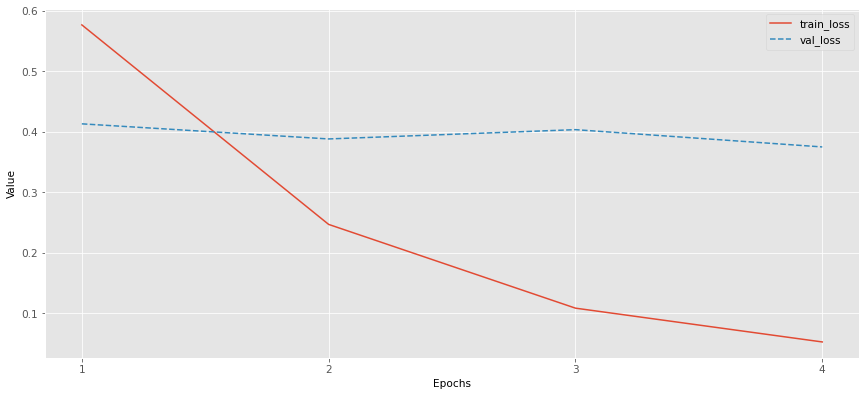

C:\Users\hp\anaconda3\lib\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


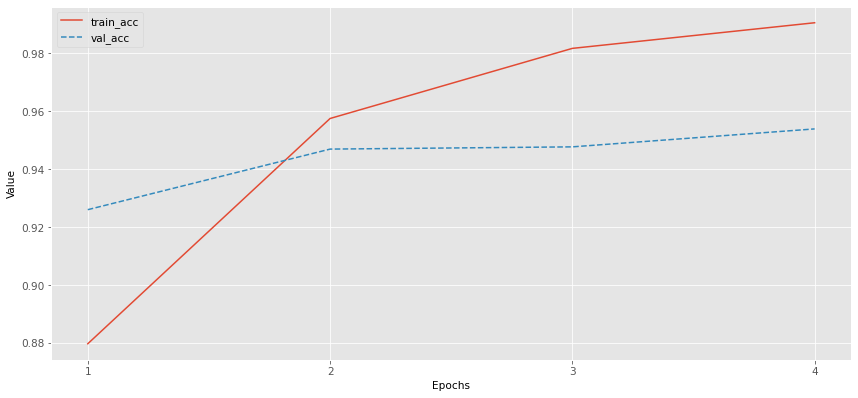

In [5]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [6]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

  0%|          | 0/1291 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    NotPhish       0.95      0.97      0.96      1534
       Phish       0.96      0.93      0.94      1048

    accuracy                           0.95      2582
   macro avg       0.95      0.95      0.95      2582
weighted avg       0.95      0.95      0.95      2582



In [7]:
torch.cuda.empty_cache()